In [1]:
##BP Points estimation taken from: https://www.kaggle.com/bguberfain/reading-and-showing-data

In [2]:
import numpy as np
import pandas as pd
import json
from os.path import join
import matplotlib.pyplot as plt
import scipy.signal as sig

In [3]:
%run Helper_Functions.py

In [4]:
%matplotlib inline

In [5]:
input_path = join('..', 'Data', 'Cuff-less Non-invasive Blood Pressure Estimation Data Set') 
num_patients = 10
time_window_secs = 10

# Functions

In [6]:
##rolling window trick numpy
# http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [7]:
def find_mins(a, num_mins, window):
    found_mins = []
    amax = a.max()
    
    hwindow = window // 2
    
    a = np.array(a)

    for i in range(num_mins):
        found_min = np.argmin(a)
        found_mins.append(found_min)
        a[found_min-hwindow:found_min+hwindow] = amax
        
    del a
        
    return sorted(found_mins)

In [8]:
with open(join(input_path, '16.json'), 'r') as f:
    data = json.load(f)

In [9]:
data_keys = ['data_PPG', 'data_ECG', 'data_PCG', 'data_FSR', 'data_BP']

In [10]:
data['data_PPG'][110000: 120000]

[2281,
 2296,
 2312,
 2328,
 2345,
 2362,
 2378,
 2394,
 2409,
 2426,
 2442,
 2456,
 2463,
 2496,
 2507,
 2526,
 2542,
 2555,
 2571,
 2584,
 2591,
 2618,
 2634,
 2648,
 2655,
 2682,
 2696,
 2706,
 2719,
 2744,
 2754,
 2763,
 2779,
 2783,
 2810,
 2815,
 2834,
 2843,
 2847,
 2866,
 2880,
 2891,
 2904,
 2911,
 2911,
 2911,
 2938,
 2939,
 2952,
 2955,
 2968,
 2975,
 2975,
 2975,
 3000,
 3002,
 3008,
 3016,
 3016,
 3018,
 3019,
 3023,
 3032,
 3032,
 3032,
 3032,
 3034,
 3035,
 3035,
 3034,
 3035,
 3035,
 3034,
 3032,
 3032,
 3023,
 3019,
 3019,
 3018,
 3016,
 3016,
 3008,
 3002,
 3000,
 2975,
 2975,
 2975,
 2971,
 2970,
 2962,
 2954,
 2946,
 2938,
 2911,
 2911,
 2907,
 2904,
 2891,
 2888,
 2880,
 2866,
 2847,
 2843,
 2840,
 2815,
 2815,
 2808,
 2795,
 2783,
 2778,
 2763,
 2760,
 2746,
 2719,
 2719,
 2712,
 2699,
 2690,
 2674,
 2655,
 2655,
 2648,
 2632,
 2624,
 2610,
 2591,
 2587,
 2575,
 2568,
 2554,
 2543,
 2527,
 2520,
 2511,
 2499,
 2490,
 2479,
 2463,
 2456,
 2443,
 2434,
 2424,
 2411,

In [11]:
print("number of BP measurements in this file is : " + str(len(data['data_BP'])))

number of BP measurements in this file is : 6


In [12]:
plt.figure(figsize=(10, 6))
data_FSR = -np.array(data['data_FSR'])
#plt.plot(data_FSR);

index = (data_FSR != 0).argmax()
data_FSR = data_FSR[index:]

<Figure size 720x432 with 0 Axes>

In [19]:
len(data['data_PPG'])

396000

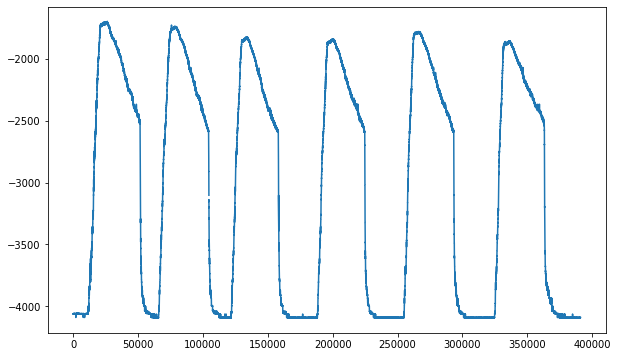

In [13]:
plt.figure(figsize=(10, 6))
max_diff = 50
data_FSR_clear = np.array(data_FSR, dtype=np.float)
data_FSR_outliers = np.abs(data_FSR[1:] - data_FSR[:-1]) > max_diff
data_FSR_outliers = np.append(data_FSR_outliers, False)
data_FSR_clear[data_FSR_outliers] = np.nan
plt.plot(data_FSR_clear);

In [24]:
##impute nan values with window average

mean_window = 10

data_FSR_roll_mean = np.nanmean(rolling_window(data_FSR_clear, mean_window), axis=-1)


data_FSR_clear = pd.Series(data_FSR_clear).interpolate().values


    
assert np.isnan(data_FSR_clear).sum() == 0

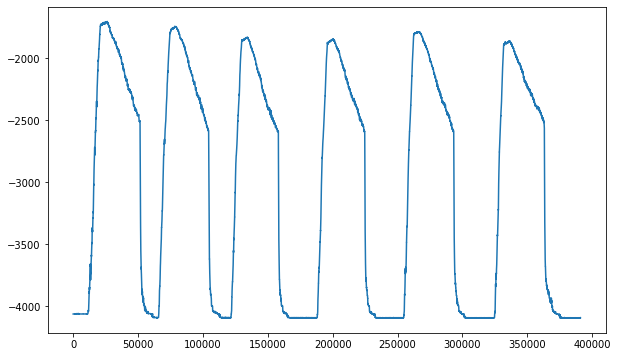

In [25]:
plt.figure(figsize=(10, 6))
data_FSR_smooth = sig.savgol_filter(data_FSR_clear, 51, 0)
plt.plot(data_FSR_smooth);

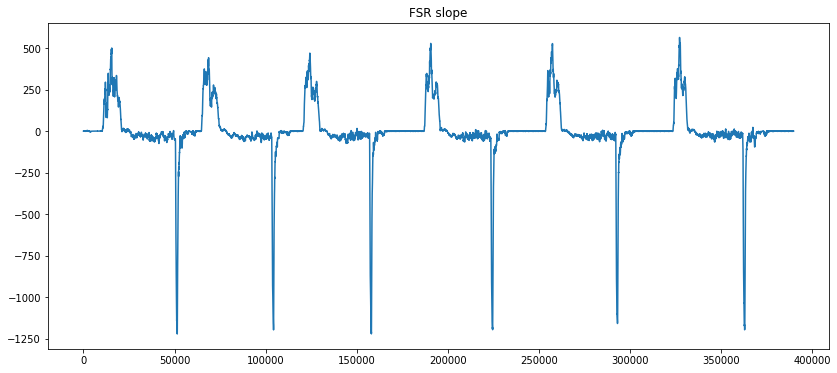

In [26]:
plt.figure(figsize=(14, 6))
diff_n = 1000
roll_window = 21
data_FSR_diff = data_FSR_smooth[diff_n:] - data_FSR_smooth[:-diff_n]
data_FSR_diff_roll = rolling_window(data_FSR_diff, roll_window).mean(axis=-1)
plt.title('FSR slope')
plt.plot(data_FSR_diff_roll);

In [27]:
num_mins = len(data['data_BP'])
min_window = 15000

data_FSR_mins = find_mins(data_FSR_diff_roll, num_mins, min_window)

In [36]:
print((data_FSR_mins + index).tolist())
print(data_FSR_mins)
print(type((data_FSR_mins + index).tolist()))
print(type(data_FSR_mins))

[56504, 109384, 163110, 229684, 298244, 368057]
[51504, 104384, 158110, 224684, 293244, 363057]
<class 'list'>
<class 'list'>


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(data_FSR_smooth, label='Smoothed FSR')

data_FSR_max, data_FSR_min = data_FSR_smooth.max(), data_FSR_smooth.min()
for m in data_FSR_mins:
    plt.vlines(m + diff_n/2, data_FSR_min, data_FSR_max, color='red')
plt.legend()
plt.title('BP measures points');

In [ ]:

data_PPG = -np.array(data['data_PPG'])
#plt.plot(data_PPG);

max_diff = 30
mean_window = 10


data_PPG_clear = np.array(data_PPG, dtype=np.float)
data_PPG_outliers = np.abs(data_PPG[1:] - data_PPG[:-1]) > max_diff
data_PPG_outliers = np.append(data_PPG_outliers, False)
data_PPG_clear[data_PPG_outliers] = np.nan
#plt.plot(data_PPG_clear[1000:10000]);

#plt.figure(figsize=(14, 6))
fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(10,8))

ax0.plot(data_PPG[10000:20000])

ax1.plot(data_PPG_clear[10000:20000])


#data_PPG_roll_mean = np.nanmean(rolling_window(data_PPG_clear, mean_window), axis=-1)

#data_PPG_clear[np.isnan(data_PPG_clear)] = \
#    data_PPG_roll_mean[np.isnan(data_PPG_clear)[:1-mean_window]]
  

data_PPG_clear = pd.Series(data_PPG_clear).interpolate().values


ax2.plot(data_PPG_clear[10000:20000])
plt.tight_layout()
plt.plot()

In [ ]:
time_window_hz = time_window_secs * 1000

plt.figure(figsize=(10, 6))

data_PPG_clear_normalized = normalize(data_PPG_clear)

bp = pd.DataFrame()
list_dicts = []

for index, mins in enumerate(data_FSR_mins):
    
    data_PPG_subsection = data_PPG_clear_normalized[(mins - time_window_hz): mins]
   # print(type(extract_features_for_window(pd.Series(data_PPG_subsection), verbose = True)))
    data_PPG_subsection_df = pd.Series(data_PPG_subsection)
    data_PPG_subsection_df.index = pd.to_datetime(data_PPG_subsection_df.index, unit='ms')
    print(extract_features_for_window(data_PPG_subsection_df, verbose=True).shape)
    window_features = extract_features_for_window(data_PPG_subsection_df, verbose=False)
    bp.loc[index, 'SBP'] = data['data_BP'][index]['SBP']
    bp.loc[index, 'DBP'] = data['data_BP'][index]['DBP']
    
    bp_dict = {'sbp': data['data_BP'][index]['SBP'], 
               'dbp': data['data_BP'][index]['DBP'],
               'ppg': data_PPG_subsection.tolist()}
    list_dicts.append(bp_dict)
    for col in window_features.columns:
        if col.find('ts') == -1:
            bp.loc[index, col+'_mean'] = window_features[col].mean()
            bp.loc[index, col+'_var'] = window_features[col].var()

In [ ]:
with open('../intermediate_data/ppg_snippets.json', 'w') as fout:
    json.dump(list_dicts , fout)

In [ ]:
bp.to_csv('../intermediate_data/bp_features', index=False)

In [ ]:
bp.shape